In [ ]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline


# Transfer Learning for Computer Vision Tutorial
**Author**: [Sasank Chilamkurthy](https://chsasank.github.io)

In this tutorial, you will learn how to train a convolutional neural network for
image classification using transfer learning. You can read more about the transfer
learning at [cs231n notes](https://cs231n.github.io/transfer-learning/)_

Quoting these notes,

    In practice, very few people train an entire Convolutional Network
    from scratch (with random initialization), because it is relatively
    rare to have a dataset of sufficient size. Instead, it is common to
    pretrain a ConvNet on a very large dataset (e.g. ImageNet, which
    contains 1.2 million images with 1000 categories), and then use the
    ConvNet either as an initialization or a fixed feature extractor for
    the task of interest.

These two major transfer learning scenarios look as follows:

-  **Finetuning the ConvNet**: Instead of random initialization, we
   initialize the network with a pretrained network, like the one that is
   trained on imagenet 1000 dataset. Rest of the training looks as
   usual.
-  **ConvNet as fixed feature extractor**: Here, we will freeze the weights
   for all of the network except that of the final fully connected
   layer. This last fully connected layer is replaced with a new one
   with random weights and only this layer is trained.


In [1]:
# License: BSD
# Author: Sasank Chilamkurthy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()   # interactive mode

## Load Data

We will use torchvision and torch.utils.data packages for loading the
data.

The problem we're going to solve today is to train a model to classify
**ants** and **bees**. We have about 120 training images each for ants and bees.
There are 75 validation images for each class. Usually, this is a very
small dataset to generalize upon, if trained from scratch. Since we
are using transfer learning, we should be able to generalize reasonably
well.

This dataset is a very small subset of imagenet.

.. Note ::
   Download the data from
   [here](https://download.pytorch.org/tutorial/hymenoptera_data.zip)
   and extract it to the current directory.



In [2]:
import urllib.request
URL = "https://download.pytorch.org/tutorial/hymenoptera_data.zip"
fname = "hymenoptera_data.zip"
urllib.request.urlretrieve(URL, fname)

('hymenoptera_data.zip', <http.client.HTTPMessage at 0x796ac82d14e0>)

In [3]:
import shutil
shutil.unpack_archive(fname, ".")

In [4]:
!ls -la

total 46200
drwxr-xr-x 1 root root     4096 Nov 29 20:02 .
drwxr-xr-x 1 root root     4096 Nov 29 20:00 ..
drwxr-xr-x 4 root root     4096 Nov 28 14:24 .config
drwxr-xr-x 4 root root     4096 Nov 29 20:02 hymenoptera_data
-rw-r--r-- 1 root root 47286322 Nov 29 20:02 hymenoptera_data.zip
drwxr-xr-x 1 root root     4096 Nov 28 14:27 sample_data


In [5]:
!apt install tree

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 15 not upgraded.
Need to get 47.9 kB of archives.
After this operation, 116 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tree amd64 2.0.2-1 [47.9 kB]
Fetched 47.9 kB in 1s (53.5 kB/s)
Selecting previously unselected package tree.
(Reading database ... 120882 files and directories currently installed.)
Preparing to unpack .../tree_2.0.2-1_amd64.deb ...
Unpacking tree (2.0.2-1) ...
Setting up tree (2.0.2-1) ...
Processing triggers for man-db (2.10.2-1) ...


In [6]:
!tree hymenoptera_data/

hymenoptera_data/
├── train
│   ├── ants
│   │   ├── 0013035.jpg
│   │   ├── 1030023514_aad5c608f9.jpg
│   │   ├── 1095476100_3906d8afde.jpg
│   │   ├── 1099452230_d1949d3250.jpg
│   │   ├── 116570827_e9c126745d.jpg
│   │   ├── 1225872729_6f0856588f.jpg
│   │   ├── 1262877379_64fcada201.jpg
│   │   ├── 1269756697_0bce92cdab.jpg
│   │   ├── 1286984635_5119e80de1.jpg
│   │   ├── 132478121_2a430adea2.jpg
│   │   ├── 1360291657_dc248c5eea.jpg
│   │   ├── 1368913450_e146e2fb6d.jpg
│   │   ├── 1473187633_63ccaacea6.jpg
│   │   ├── 148715752_302c84f5a4.jpg
│   │   ├── 1489674356_09d48dde0a.jpg
│   │   ├── 149244013_c529578289.jpg
│   │   ├── 150801003_3390b73135.jpg
│   │   ├── 150801171_cd86f17ed8.jpg
│   │   ├── 154124431_65460430f2.jpg
│   │   ├── 162603798_40b51f1654.jpg
│   │   ├── 1660097129_384bf54490.jpg
│   │   ├── 167890289_dd5ba923f3.jpg
│   │   ├── 1693954099_46d4c20605.jpg
│   │   ├── 175998972.jpg
│   │   ├── 178538489_bec7649292.jpg
│   │   ├── 1804095607_0341701e1c.jpg
│   │  

In [7]:
!tree --filelimit 10 hymenoptera_data/

hymenoptera_data/
├── train
│   ├── ants  [124 entries exceeds filelimit, not opening dir]
│   └── bees  [121 entries exceeds filelimit, not opening dir]
└── val
    ├── ants  [70 entries exceeds filelimit, not opening dir]
    └── bees  [83 entries exceeds filelimit, not opening dir]

6 directories, 0 files


In [8]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [9]:
class_names

['ants', 'bees']

### Visualize a few images
Let's visualize a few training images so as to understand the data
augmentations.



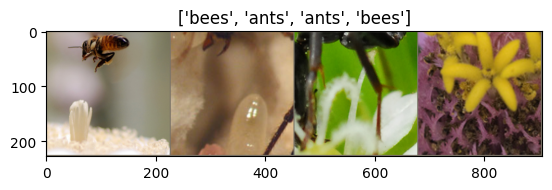

In [11]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Training the model

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [12]:
help(TemporaryDirectory)

Help on class TemporaryDirectory in module tempfile:

class TemporaryDirectory(builtins.object)
 |  TemporaryDirectory(suffix=None, prefix=None, dir=None, ignore_cleanup_errors=False)
 |  
 |  Create and return a temporary directory.  This has the same
 |  behavior as mkdtemp but can be used as a context manager.  For
 |  example:
 |  
 |      with TemporaryDirectory() as tmpdir:
 |          ...
 |  
 |  Upon exiting the context, the directory and everything contained
 |  in it are removed.
 |  
 |  Methods defined here:
 |  
 |  __enter__(self)
 |  
 |  __exit__(self, exc, value, tb)
 |  
 |  __init__(self, suffix=None, prefix=None, dir=None, ignore_cleanup_errors=False)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  __repr__(self)
 |      Return repr(self).
 |  
 |  cleanup(self)
 |  
 |  ----------------------------------------------------------------------
 |  Class methods defined here:
 |  
 |  __class_getitem__ = GenericAlias(...) from builtins.t

In [13]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

### Visualizing the model predictions

Generic function to display predictions for a few images




In [16]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## Finetuning the ConvNet

Load a pretrained model and reset final fully connected layer.




In [17]:
model_resnet = models.resnet18(weights='IMAGENET1K_V1')

In [18]:
model_resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [30]:
import torchsummary
model_resnet = model_resnet.to(device)
torchsummary.summary(model_resnet, input_size=(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [22]:
model_resnet.fc.in_features

512

In [23]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [24]:
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [25]:
torchvision.models.list_models()

['alexnet',
 'convnext_base',
 'convnext_large',
 'convnext_small',
 'convnext_tiny',
 'deeplabv3_mobilenet_v3_large',
 'deeplabv3_resnet101',
 'deeplabv3_resnet50',
 'densenet121',
 'densenet161',
 'densenet169',
 'densenet201',
 'efficientnet_b0',
 'efficientnet_b1',
 'efficientnet_b2',
 'efficientnet_b3',
 'efficientnet_b4',
 'efficientnet_b5',
 'efficientnet_b6',
 'efficientnet_b7',
 'efficientnet_v2_l',
 'efficientnet_v2_m',
 'efficientnet_v2_s',
 'fasterrcnn_mobilenet_v3_large_320_fpn',
 'fasterrcnn_mobilenet_v3_large_fpn',
 'fasterrcnn_resnet50_fpn',
 'fasterrcnn_resnet50_fpn_v2',
 'fcn_resnet101',
 'fcn_resnet50',
 'fcos_resnet50_fpn',
 'googlenet',
 'inception_v3',
 'keypointrcnn_resnet50_fpn',
 'lraspp_mobilenet_v3_large',
 'maskrcnn_resnet50_fpn',
 'maskrcnn_resnet50_fpn_v2',
 'maxvit_t',
 'mc3_18',
 'mnasnet0_5',
 'mnasnet0_75',
 'mnasnet1_0',
 'mnasnet1_3',
 'mobilenet_v2',
 'mobilenet_v3_large',
 'mobilenet_v3_small',
 'mvit_v1_b',
 'mvit_v2_s',
 'quantized_googlenet',
 '

In [26]:
torchsummary.summary(model_ft, input_size=(3,244,244))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 122, 122]           9,408
       BatchNorm2d-2         [-1, 64, 122, 122]             128
              ReLU-3         [-1, 64, 122, 122]               0
         MaxPool2d-4           [-1, 64, 61, 61]               0
            Conv2d-5           [-1, 64, 61, 61]          36,864
       BatchNorm2d-6           [-1, 64, 61, 61]             128
              ReLU-7           [-1, 64, 61, 61]               0
            Conv2d-8           [-1, 64, 61, 61]          36,864
       BatchNorm2d-9           [-1, 64, 61, 61]             128
             ReLU-10           [-1, 64, 61, 61]               0
       BasicBlock-11           [-1, 64, 61, 61]               0
           Conv2d-12           [-1, 64, 61, 61]          36,864
      BatchNorm2d-13           [-1, 64, 61, 61]             128
             ReLU-14           [-1, 64,

### Train and evaluate

It should take around 15-25 min on CPU. On GPU though, it takes less than a
minute.




In [27]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6405 Acc: 0.7008
val Loss: 0.2648 Acc: 0.9020

Epoch 1/24
----------
train Loss: 0.4561 Acc: 0.7992
val Loss: 0.2058 Acc: 0.9085

Epoch 2/24
----------
train Loss: 0.4585 Acc: 0.8238
val Loss: 0.2614 Acc: 0.8824

Epoch 3/24
----------
train Loss: 0.6984 Acc: 0.7377
val Loss: 0.2921 Acc: 0.8824

Epoch 4/24
----------
train Loss: 0.4110 Acc: 0.8443
val Loss: 0.4720 Acc: 0.8431

Epoch 5/24
----------
train Loss: 0.6531 Acc: 0.7500
val Loss: 0.3033 Acc: 0.8824

Epoch 6/24
----------
train Loss: 0.6157 Acc: 0.7746
val Loss: 0.8400 Acc: 0.7582

Epoch 7/24
----------
train Loss: 0.4270 Acc: 0.8115
val Loss: 0.3237 Acc: 0.9085

Epoch 8/24
----------
train Loss: 0.3015 Acc: 0.8770
val Loss: 0.2906 Acc: 0.9085

Epoch 9/24
----------
train Loss: 0.4306 Acc: 0.8320
val Loss: 0.2729 Acc: 0.9346

Epoch 10/24
----------
train Loss: 0.2823 Acc: 0.8566
val Loss: 0.2800 Acc: 0.9085

Epoch 11/24
----------
train Loss: 0.2489 Acc: 0.8811
val Loss: 0.2419 Acc: 0.9216

Ep

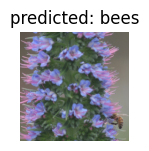

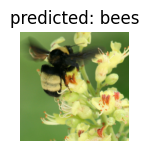

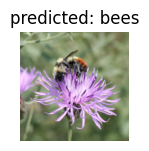

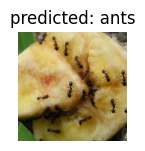

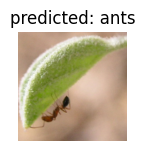

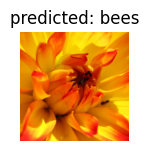

In [28]:
visualize_model(model_ft)

## ConvNet as fixed feature extractor

Here, we need to freeze all the network except the final layer. We need
to set ``requires_grad = False`` to freeze the parameters so that the
gradients are not computed in ``backward()``.

You can read more about this in the documentation
[here](https://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward)_.




In [31]:
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

### Train and evaluate

On CPU this will take about half the time compared to previous scenario.
This is expected as gradients don't need to be computed for most of the
network. However, forward does need to be computed.




In [32]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5304 Acc: 0.7254
val Loss: 0.2581 Acc: 0.8954

Epoch 1/24
----------
train Loss: 0.4953 Acc: 0.7664
val Loss: 0.4347 Acc: 0.8235

Epoch 2/24
----------
train Loss: 0.4099 Acc: 0.8361
val Loss: 0.1788 Acc: 0.9477

Epoch 3/24
----------
train Loss: 0.4804 Acc: 0.7787
val Loss: 0.1688 Acc: 0.9477

Epoch 4/24
----------
train Loss: 0.4202 Acc: 0.8238
val Loss: 0.3625 Acc: 0.8366

Epoch 5/24
----------
train Loss: 0.4440 Acc: 0.8115
val Loss: 0.1848 Acc: 0.9412

Epoch 6/24
----------
train Loss: 0.3882 Acc: 0.8279
val Loss: 0.1956 Acc: 0.9412

Epoch 7/24
----------
train Loss: 0.4067 Acc: 0.8238
val Loss: 0.1832 Acc: 0.9412

Epoch 8/24
----------
train Loss: 0.3613 Acc: 0.8566
val Loss: 0.1832 Acc: 0.9346

Epoch 9/24
----------
train Loss: 0.3787 Acc: 0.8402
val Loss: 0.1660 Acc: 0.9542

Epoch 10/24
----------
train Loss: 0.3284 Acc: 0.8689
val Loss: 0.2060 Acc: 0.9346

Epoch 11/24
----------
train Loss: 0.3123 Acc: 0.8648
val Loss: 0.1886 Acc: 0.9412

Ep

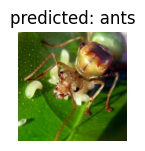

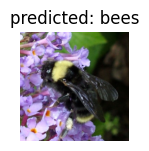

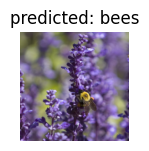

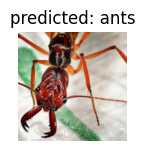

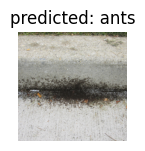

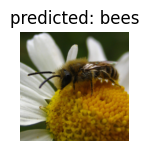

In [33]:
visualize_model(model_conv)

plt.ioff()
plt.show()

## Inference on custom images

Use the trained model to make predictions on custom images and visualize
the predicted class labels along with the images.




In [34]:
def visualize_model_predictions(model,img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = data_transforms['val'](img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0]]}')
        imshow(img.cpu().data[0])

        model.train(mode=was_training)

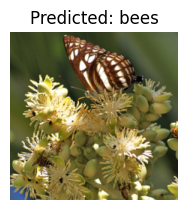

In [36]:
visualize_model_predictions(
    model_conv,
    img_path='hymenoptera_data/val/bees/72100438_73de9f17af.jpg'
)

plt.ioff()
plt.show()

## Further Learning

If you would like to learn more about the applications of transfer learning,
checkout our [Quantized Transfer Learning for Computer Vision Tutorial](https://pytorch.org/tutorials/intermediate/quantized_transfer_learning_tutorial.html).



